In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [3]:
weaps_data = pd.read_csv('streamlit-app/Terraria DPS_TV1.4.4.9_V3.csv')
weaps_label = weaps_data["NAME"]

weaps_data_proc = weaps_data.drop(columns = ["NAME", "OBSERVATIONS"])

In [4]:
# Check for any columns with null type that needs to be imputed
weaps_data.isnull().any()

NAME                                     False
CLASS                                    False
GAME PROGRESSION                         False
DPS (SINGLE TARGET)                      False
DPS (MULTI TARGET)                        True
DPS (SINGLE TARGET + PROYECTILE ONLY)     True
DPS (MULTI TARGET + PROYECTILE ONLY)      True
OBSERVATIONS                              True
dtype: bool

In [14]:
# Check for unique set of values for class
weaps_data["CLASS"].unique()

array(['Melee', 'Mage', 'Ranger', 'Summoner'], dtype=object)

# Check for unique set of values for class


In [15]:
# Check for unique set of values for game progresion
weaps_data["GAME PROGRESSION"].unique()

array(['Post-Moonlord', 'Post-Cultist', 'Post-WoF', 'Post-EoL',
       'Post-Golem', 'Post-Plantera', 'Post-Destroyer',
       'Post-SkeletronPrime', 'Post-Brain/Worm', 'Post-Twins',
       'Post-Skeletron', 'Pre-Boss', 'Post-QueenBee', 'Post-Deerclops',
       'Post-Eye', 'Post-QueenSlime'], dtype=object)

In [5]:
# Define ordinal categories for Game progression
progress = ["Pre-Boss", # Pre-hardmode
            "Post-Eye",
            "Post-Brain/Worm",
            "Post-QueenBee",
            "Post-Skeletron",
            "Post-Deerclops",
            "Post-WoF",
            "Post-QueenSlime", # Hardmode
            "Post-Twins",
            "Post-Destroyer",
            "Post-SkeletronPrime",
            "Post-Plantera",
            "Post-Golem",
            "Post-EoL",
            "Post-Cultist",
            "Post-Moonlord"
]

In [6]:
# Implement Imputer
from sklearn.impute import SimpleImputer
imp_zero_constant = SimpleImputer(strategy = "constant", fill_value = 0)

In [7]:
# Implement One-hot Encoder and Ordinal Encoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
ohe = OneHotEncoder(sparse_output=False)
ode = OrdinalEncoder(categories = [progress])

In [8]:
# Column Transformer
from sklearn.compose import make_column_transformer

col_trans = make_column_transformer(
    (ohe, ["CLASS"]),
    (ode, ["GAME PROGRESSION"]),
    (imp_zero_constant, ["DPS (MULTI TARGET)", "DPS (SINGLE TARGET + PROYECTILE ONLY)","DPS (MULTI TARGET + PROYECTILE ONLY)"]),
    remainder = 'passthrough',
    verbose_feature_names_out = False
)
col_trans.set_output(transform='pandas')
weaps_data_proc = col_trans.fit_transform(weaps_data_proc)
weaps_data_proc.isnull().any()


CLASS_Mage                               False
CLASS_Melee                              False
CLASS_Ranger                             False
CLASS_Summoner                           False
GAME PROGRESSION                         False
DPS (MULTI TARGET)                       False
DPS (SINGLE TARGET + PROYECTILE ONLY)    False
DPS (MULTI TARGET + PROYECTILE ONLY)     False
DPS (SINGLE TARGET)                      False
dtype: bool

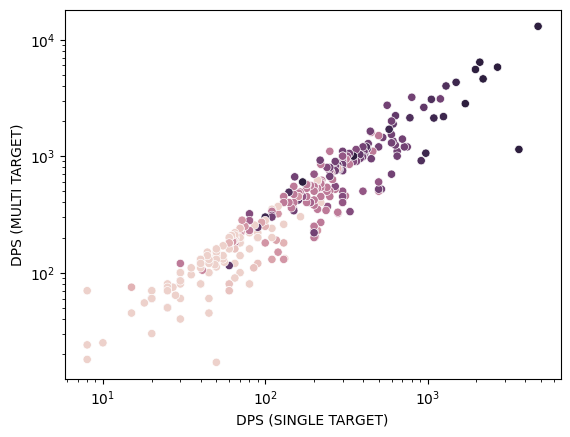

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data = weaps_data_proc, x = 'DPS (SINGLE TARGET)', y = 'DPS (MULTI TARGET)', hue = 'GAME PROGRESSION', legend = False)
plt.yscale('log')
plt.xscale('log')
plt.show()

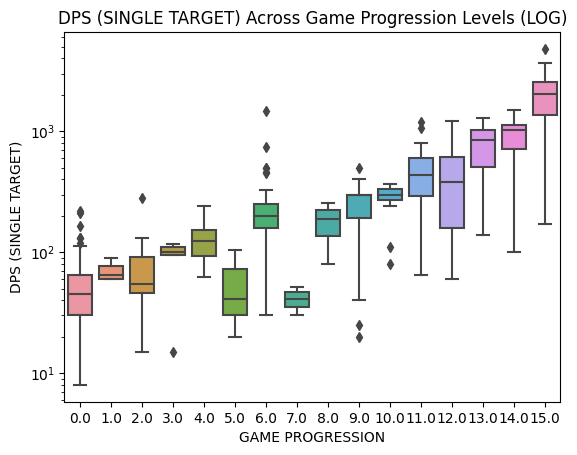

In [ ]:
dps_columns = ['DPS (SINGLE TARGET)', 'DPS (MULTI TARGET)',
               'DPS (SINGLE TARGET + PROYECTILE ONLY)', 'DPS (MULTI TARGET + PROYECTILE ONLY)']

# Boxplot for DPS across game progression levels
sns.boxplot(data=weaps_data_proc, x='GAME PROGRESSION', y='DPS (SINGLE TARGET)')
plt.title('DPS (SINGLE TARGET) Across Game Progression Levels (LOG)')
plt.yscale('log')
plt.show()

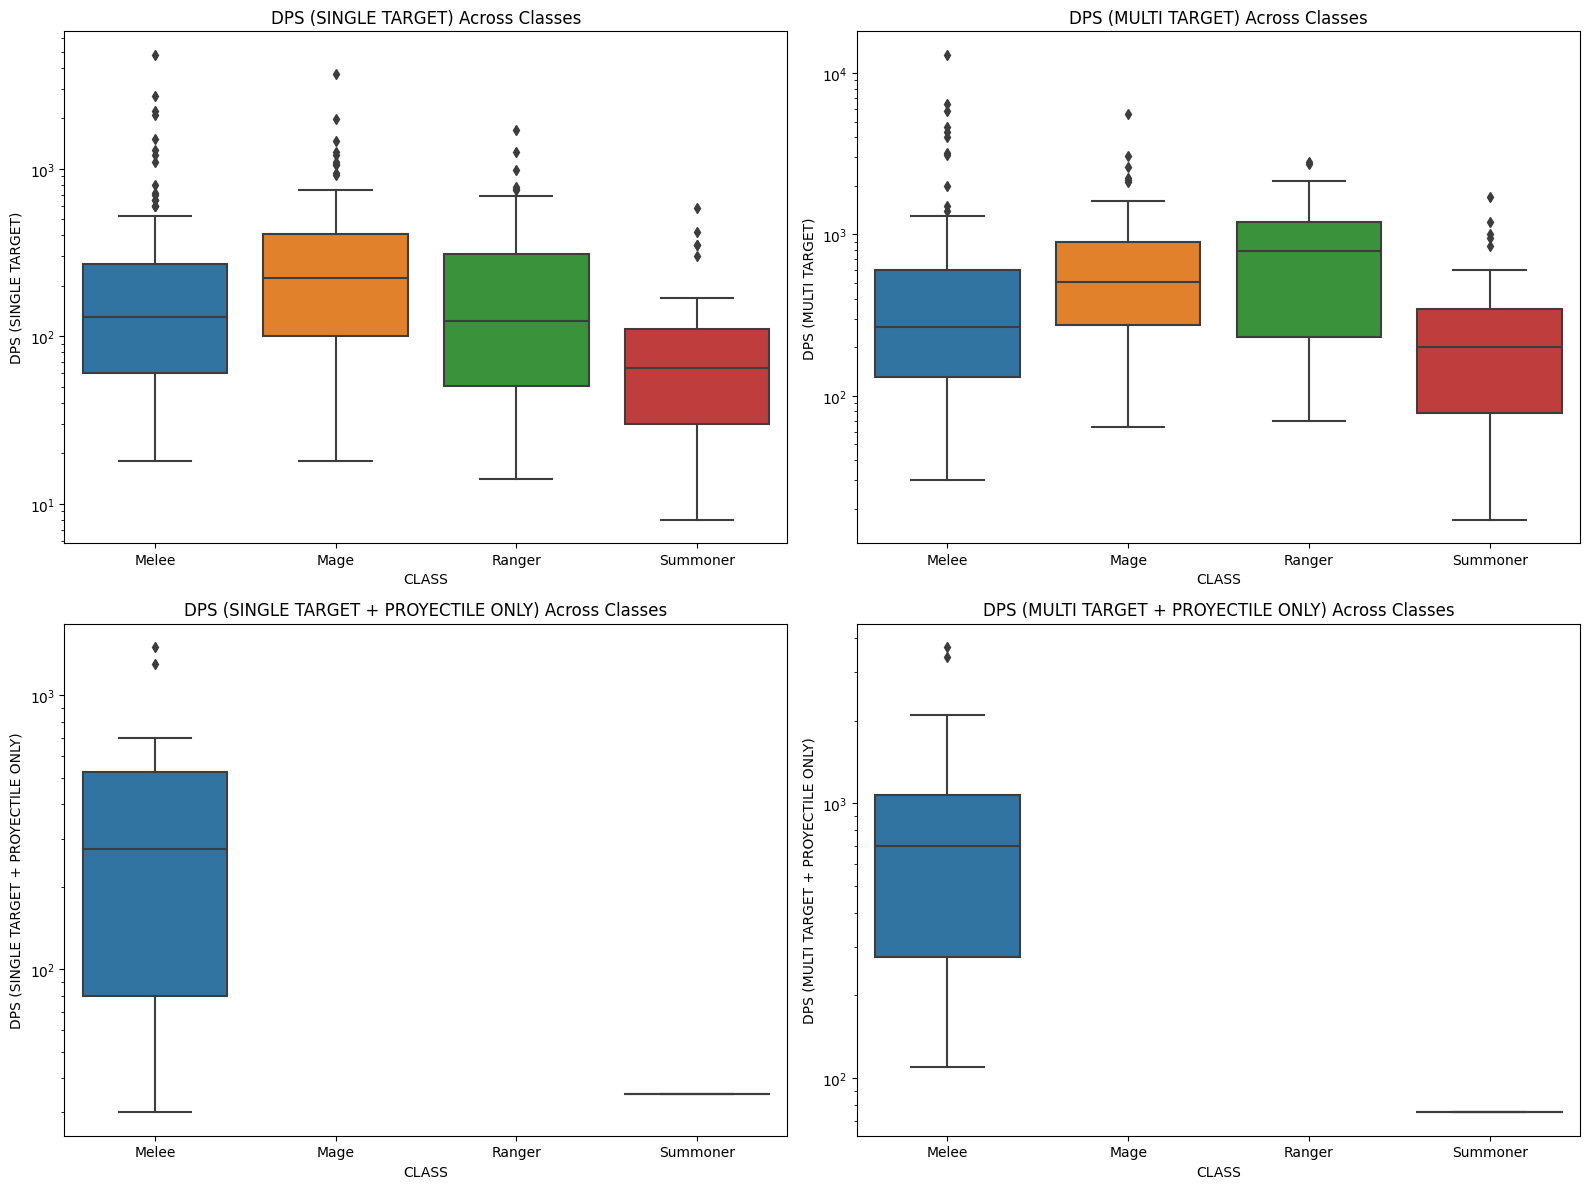

In [13]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DPS column and create a boxplot
for i, column in enumerate(dps_columns):
    sns.boxplot(data=weaps_data, x='CLASS', y=column, ax=axes[i])
    axes[i].set_title(f'{column} Across Classes')
    axes[i].set_yscale('log')  # Set y-axis to log scale

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

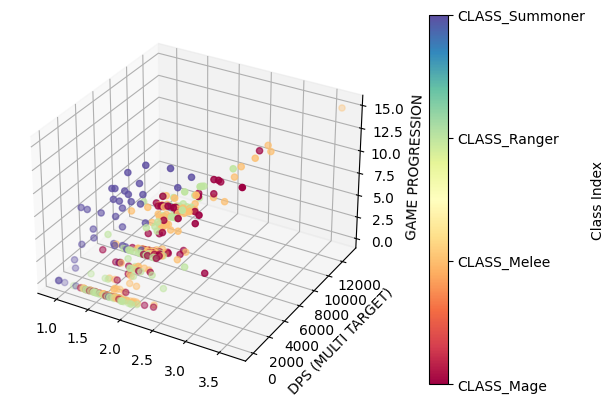

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class_columns = ['CLASS_Mage', 'CLASS_Melee', 'CLASS_Ranger', 'CLASS_Summoner']
class_labels = [col for col in class_columns if col in weaps_data_proc.columns]

# Convert the one-hot encoded class columns to a single column with class indices
class_indices = weaps_data_proc[class_labels].idxmax(axis=1).str.replace('CLASS_', '').astype('category').cat.codes

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Example data
x = weaps_data_proc['DPS (SINGLE TARGET)']
y = weaps_data_proc['DPS (MULTI TARGET)']
z = weaps_data_proc['GAME PROGRESSION']

scatter = ax.scatter(np.log10(x + 1e-9), y, z, c=class_indices, cmap='Spectral', marker='o')  # Adding a small constant to avoid log(0)ax.set_xlabel('DPS (SINGLE TARGET)')
ax.set_ylabel('DPS (MULTI TARGET)')
ax.set_zlabel('GAME PROGRESSION')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Class Index')
cbar.set_ticks([i for i in range(len(class_labels))])
cbar.set_ticklabels(class_labels)

plt.show()

# Implement KNN

In [21]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(weaps_data_proc)

In [22]:
from sklearn.neighbors import NearestNeighbors

# Fit the Nearest Neighbors model
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(scaled_features)

NearestNeighbors(metric='euclidean')

In [23]:
# Find the closest weapons to a given weapon
weapon_index = 240 # Example: Index of the weapon of interest
distances, indices = knn.kneighbors([scaled_features[weapon_index]])

# Exclude the weapon itself and get the recommendations
weaps_recos = weaps_label.iloc[indices[0][1:]]
print(f"Recommended weapon similar to {weaps_label[weapon_index]}:")

for i, weap in enumerate(weaps_recos):
    print(f"\t{i} {weap}")

Recommended weapon similar to Revolver:
	0 Paintball Gun
	1 Musket
	2 The Undertaker
	3 Flintlock Pistol


In [15]:
# Save Dataset
weaps_data_proc['NAME'] = weaps_data['NAME']
weaps_data_proc.to_csv('cleaned-data.csv', index=False)

In [25]:
# Save the Model
import joblib
joblib.dump(knn, 'knn_model.pkl')

['knn_model.pkl']